In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-029.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549AB-200-010.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse/200X/adenosis/SOB_B_A-14-22549CD-200-018.png
/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Databa

In [2]:
# Imports & config
import os, re, glob, random, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paths (adjust if needed)
DATA_ROOT = "/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_multiclasse"
# We’ll glob recursively for image files:
IMAGE_EXTS = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")

# Training settings
IMG_SIZE = (299, 299)                       # EfficientNetV2B0 default can go 300; 299 is fine
BATCH_SIZE = 32
EPOCHS_FROZEN = 5                           # phase 1
EPOCHS_UNFROZEN = 10                        # phase 2
INITIAL_LR = 1e-3
FINE_TUNE_LR = 1e-4

# Model / classes
CLASSES = [
    "adenosis",              # benign
    "fibroadenoma",
    "phyllodes_tumor",
    "tubular_adenoma",
    "ductal_carcinoma",      # malignant
    "lobular_carcinoma",
    "mucinous_carcinoma",
    "papillary_carcinoma"
]
NUM_CLASSES = len(CLASSES)
CLASS2IDX = {c:i for i,c in enumerate(CLASSES)}
IDX2CLASS = {i:c for c,i in CLASS2IDX.items()}

2025-08-13 02:01:15.636540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755050475.862720      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755050475.930367      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [3]:
# Index all images and parse metadata
def list_images(root, exts=IMAGE_EXTS):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return sorted(files)

all_files = list_images(DATA_ROOT)
print("Total files found:", len(all_files))

# Helper to infer class from path (last folder among known classes)
def infer_class_from_path(p):
    p_lower = p.lower()
    for c in CLASSES:
        if os.sep + c + os.sep in p_lower:
            return c
    # Fallback: try any segment
    parts = [s for s in p_lower.split(os.sep) if s]
    for s in parts[::-1]:
        if s in CLASSES:
            return s
    return None

# Parse patient id from filename.
# BreakHis filenames look like:  "SOB_B_A-14-22549G-400-019.png"
# We'll grab the longest digit block as patient id (robust across variants).
def extract_patient_id(filename):
    base = os.path.basename(filename)
    digit_groups = re.findall(r'(\d+)', base)
    if not digit_groups:
        return base  # fallback
    # choose the longest numeric group as "patient id"
    return max(digit_groups, key=len)

# Extract magnification if present (e.g., "40X", "100X", "200X", "400X")
def extract_magnification(path):
    m = re.search(r'(\d{2,3})x', path.lower())
    return m.group(1) if m else "unk"

rows = []
for p in all_files:
    cls = infer_class_from_path(p)
    if cls is None: 
        continue
    pid = extract_patient_id(p)
    mag = extract_magnification(p)
    rows.append((p, cls, pid, mag))

df = pd.DataFrame(rows, columns=["path","label","patient_id","magnification"])
df = df[df["label"].isin(CLASSES)].reset_index(drop=True)

print(df.head(3))
print("Images per class:\n", df["label"].value_counts())
print("Unique patients:", df["patient_id"].nunique())

Total files found: 7909
                                                path     label patient_id  \
0  /kaggle/input/breakhis-breast-cancer-histopath...  adenosis      22549   
1  /kaggle/input/breakhis-breast-cancer-histopath...  adenosis      22549   
2  /kaggle/input/breakhis-breast-cancer-histopath...  adenosis      22549   

  magnification  
0           100  
1           100  
2           100  
Images per class:
 label
ductal_carcinoma       3451
fibroadenoma           1014
mucinous_carcinoma      792
lobular_carcinoma       626
tubular_adenoma         569
papillary_carcinoma     560
phyllodes_tumor         453
adenosis                444
Name: count, dtype: int64
Unique patients: 70


In [4]:
# Patient-wise stratified split

# Encode labels for stratification (multiclass)
y = df["label"].map(CLASS2IDX).values
groups = df["patient_id"].values

# We want: train 70%, val 15%, test 15% by IMAGE count, but grouped by patient.
# We'll do it in two stages with StratifiedGroupKFold:
# 1) Train+Val (85%) vs Test (15%)
# 2) Train (70/85) vs Val (15/85) inside Train+Val

def group_stratified_split(X_idx, y, groups, test_size, random_state=SEED):
    sgkf = StratifiedGroupKFold(n_splits=int(1/(test_size)), shuffle=True, random_state=random_state)
    # Take first split
    for train_idx, test_idx in sgkf.split(X_idx, y, groups):
        return train_idx, test_idx

X_idx = np.arange(len(df))

# Stage 1: hold-out test 15%
trainval_idx, test_idx = group_stratified_split(X_idx, y, groups, test_size=0.15, random_state=SEED)

# Stage 2: from trainval, carve out val 15/85~=17.65% of trainval
df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
y_tv = df_trainval["label"].map(CLASS2IDX).values
groups_tv = df_trainval["patient_id"].values
X_tv_idx = np.arange(len(df_trainval))

# desired val fraction relative to trainval:
val_rel = 0.15 / 0.85   # ≈ 0.1765
train_idx_tv, val_idx_tv = group_stratified_split(X_tv_idx, y_tv, groups_tv, test_size=val_rel, random_state=SEED)

# Map back to original indices
train_idx = df_trainval.index[train_idx_tv].values
val_idx   = df_trainval.index[val_idx_tv].values

df_train = df.iloc[train_idx].reset_index(drop=True)
df_val   = df.iloc[val_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

def summarize_split(d, name):
    print(f"{name}: n={len(d)}, patients={d['patient_id'].nunique()}")
    print(d["label"].value_counts(normalize=True).sort_index().round(3))
    print()

summarize_split(df_train, "TRAIN")
summarize_split(df_val,   "VAL")
summarize_split(df_test,  "TEST")

TRAIN: n=5704, patients=70
label
adenosis               0.072
ductal_carcinoma       0.494
fibroadenoma           0.115
lobular_carcinoma      0.068
mucinous_carcinoma     0.092
papillary_carcinoma    0.055
phyllodes_tumor        0.052
tubular_adenoma        0.053
Name: proportion, dtype: float64

VAL: n=1156, patients=51
label
adenosis               0.028
ductal_carcinoma       0.521
fibroadenoma           0.091
lobular_carcinoma      0.069
mucinous_carcinoma     0.056
papillary_carcinoma    0.090
phyllodes_tumor        0.043
tubular_adenoma        0.102
Name: proportion, dtype: float64

TEST: n=1049, patients=11
label
ductal_carcinoma       0.711
lobular_carcinoma      0.117
mucinous_carcinoma     0.086
papillary_carcinoma    0.086
Name: proportion, dtype: float64



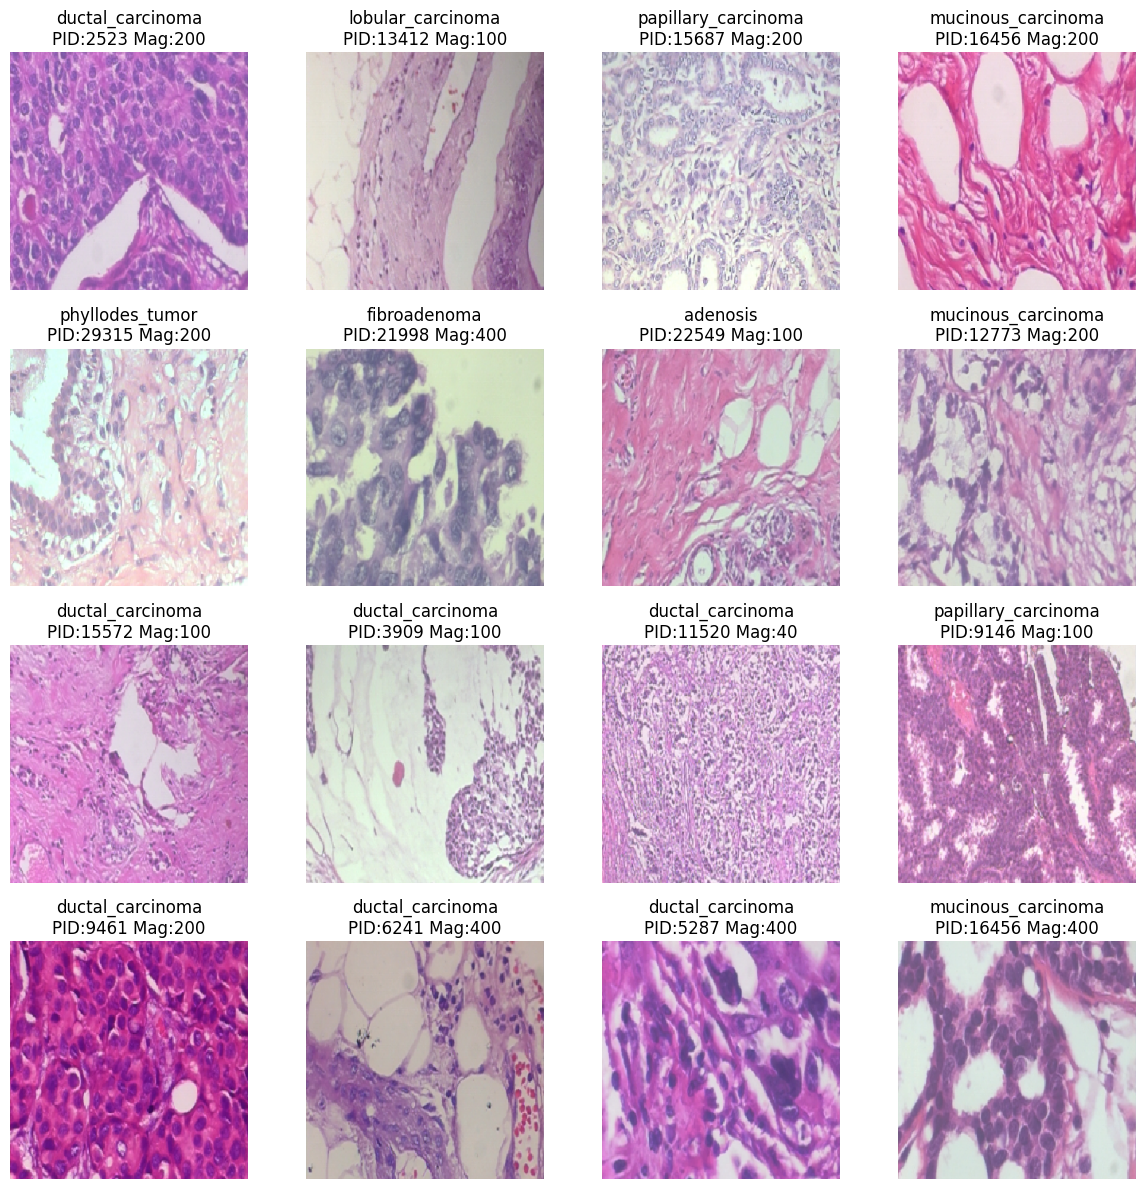

In [5]:
# Plot random examples
def plot_examples(df_subset, n=16):
    sample = df_subset.sample(n=min(n, len(df_subset)), random_state=SEED).reset_index(drop=True)
    cols = int(math.sqrt(n)); cols = max(cols, 4)
    rows = int(math.ceil(n/cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for i, row in sample.iterrows():
        img = keras.utils.load_img(row["path"], target_size=IMG_SIZE)
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"{row['label']}\nPID:{row['patient_id']} Mag:{row['magnification']}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_examples(df_train, n=16)

In [6]:
# tf.data loaders
AUTO = tf.data.AUTOTUNE

def preprocess_image(path, label_idx, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    #img = tf.cast(img, tf.float32) / 255.0

    if augment:
        # lightweight augs; feel free to expand
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.08)
        img = tf.image.random_contrast(img, 0.8, 1.2)
    return img, tf.one_hot(label_idx, NUM_CLASSES, dtype=tf.float32)

def make_dataset(df_, augment=False, shuffle=False, batch_size=BATCH_SIZE):
    paths = df_["path"].values
    labels = df_["label"].map(CLASS2IDX).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(df_), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, y: preprocess_image(p, y, augment=augment), num_parallel_calls=AUTO)
    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds

train_ds = make_dataset(df_train, augment=True,  shuffle=True)
val_ds   = make_dataset(df_val,   augment=False, shuffle=False)
test_ds  = make_dataset(df_test,  augment=False, shuffle=False)

I0000 00:00:1755050495.687557      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
# Build model & phase-1 training 
def build_model():
    eff = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
    )
    eff.trainable = False  # Phase 1: frozen

    # Wrap in a named container so we can fetch it later as "backbone"
    backbone = keras.Sequential([eff], name="backbone")

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = keras.applications.efficientnet_v2.preprocess_input(inputs)  # keep this if your loader doesn't /255
    x = backbone(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.35)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    model = keras.Model(inputs, outputs)
    return model

model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# Save WEIGHTS ONLY to reload safely later
ckpt = keras.callbacks.ModelCheckpoint(
    filepath="model_phase1.weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    verbose=1
)
early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

hist1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FROZEN,
    callbacks=[ckpt, early],
    verbose=1
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ backbone (Sequential)           │ (None, 10, 10, 1280)   │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,929,560 (22.62 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Epoch 1/5


I0000 00:00:1755050517.970543      98 service.cc:148] XLA service 0x7f79b8003810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755050517.971313      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755050520.271193      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/179 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.0573 - loss: 2.2938    

I0000 00:00:1755050532.642116      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4741 - loss: 1.5847
Epoch 1: val_accuracy improved from -inf to 0.60813, saving model to model_phase1.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 241ms/step - accuracy: 0.4745 - loss: 1.5837 - val_accuracy: 0.6081 - val_loss: 1.1860
Epoch 2/5
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6103 - loss: 1.1396
Epoch 2: val_accuracy improved from 0.60813 to 0.62889, saving model to model_phase1.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.6104 - loss: 1.1392 - val_accuracy: 0.6289 - val_loss: 1.1069
Epoch 3/5
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6426 - loss: 1.0060
Epoch 3: val_accuracy improved from 0.62889 to 0.67474, saving model to model_phase1.weights.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.6426 - loss: 1.0059 - val_accuracy: 0.6747 - val_loss: 1.0197
Epoch 4/5
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6595 - loss: 0.9722
Epoch 4: val_accuracy 

In [8]:
# Phase 2: Fine-tune — unfreeze top layers of the base

# Optional: reload best Phase‑1 weights
model.load_weights("model_phase1.weights.h5")

# Get the wrapper, then the inner EfficientNetV2 model
backbone = model.get_layer("backbone")           # this is a Sequential([eff])
inner = backbone.layers[0]                       # the actual EfficientNetV2B0 model
print("Backbone wrapper:", backbone.name, "| inner model name:", inner.name)

# Unfreeze last ~30% of INNER layers; keep BatchNorm frozen for stability
n_total = len(inner.layers)
n_unfreeze = max(1, int(0.3 * n_total))
start = n_total - n_unfreeze

for i, layer in enumerate(inner.layers):
    if i >= start and not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile with a lower LR for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

ckpt2 = keras.callbacks.ModelCheckpoint(
    filepath="model_phase2.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
early2 = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    restore_best_weights=True
)

hist2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_UNFROZEN,
    callbacks=[ckpt2, early2],
    verbose=1
)

Backbone wrapper: backbone | inner model name: efficientnetv2-b0
Epoch 1/10


E0000 00:00:1755050663.418234      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755050663.625524      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7016 - loss: 0.8514
Epoch 1: val_accuracy improved from -inf to 0.71021, saving model to model_phase2.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 214ms/step - accuracy: 0.7017 - loss: 0.8512 - val_accuracy: 0.7102 - val_loss: 0.8590
Epoch 2/10
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7458 - loss: 0.7052
Epoch 2: val_accuracy did not improve from 0.71021
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.7460 - loss: 0.7049 - val_accuracy: 0.6894 - val_loss: 0.9133
Epoch 3/10
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7912 - loss: 0.5819
Epoch 3: val_accuracy did not improve from 0.71021
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.7912 - loss: 0.5818 - val_accuracy: 0.6894 - val_loss: 0.8551
Epoch 4/10
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8209 - loss: 0.4943
Epoch 4: val_accuracy did not improve from 0.71021
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.8209 -

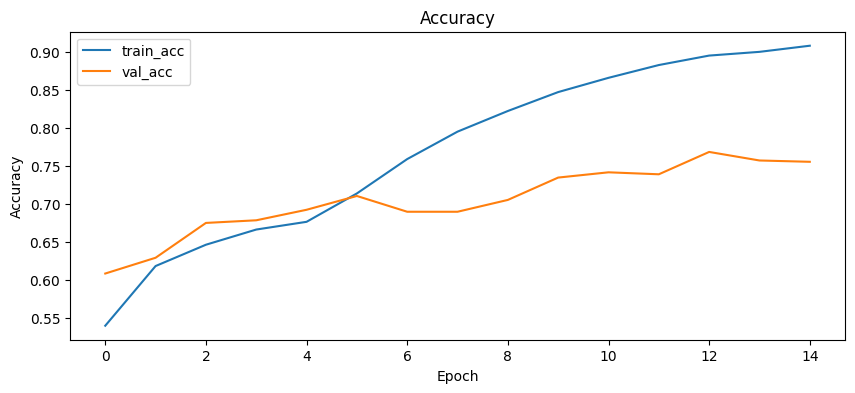

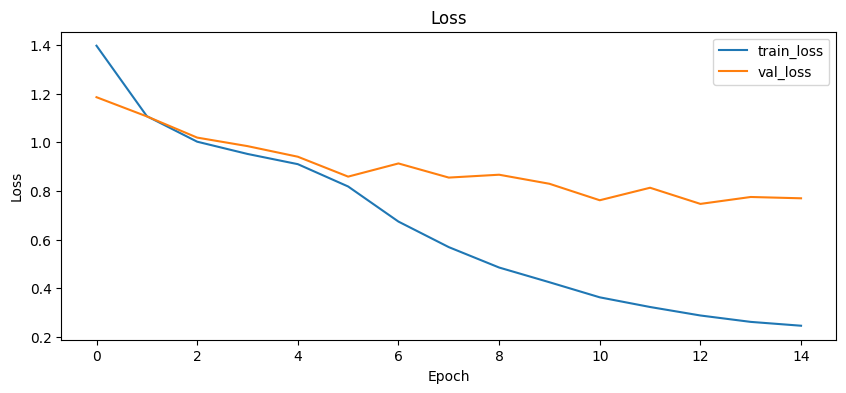

In [9]:
# Training curves
def merge_histories(h1, h2):
    history = {}
    for k in set(list(h1.history.keys()) + list(h2.history.keys())):
        history[k] = h1.history.get(k, []) + h2.history.get(k, [])
    return history

history = merge_histories(hist1, hist2)

plt.figure(figsize=(10,4))
plt.plot(history["accuracy"], label="train_acc")
plt.plot(history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history["loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
plt.show()

Test label counts: [  0   0   0   0 746 123  90  90]
Classification Report (per class):
                     precision    recall  f1-score   support

           adenosis     0.0000    0.0000    0.0000         0
       fibroadenoma     0.0000    0.0000    0.0000         0
    phyllodes_tumor     0.0000    0.0000    0.0000         0
    tubular_adenoma     0.0000    0.0000    0.0000         0
   ductal_carcinoma     0.8354    0.9249    0.8779       746
  lobular_carcinoma     0.4066    0.3008    0.3458       123
 mucinous_carcinoma     0.9388    0.5111    0.6619        90
papillary_carcinoma     0.9310    0.6000    0.7297        90

          micro avg     0.7884    0.7884    0.7884      1049
          macro avg     0.3890    0.2921    0.3269      1049
       weighted avg     0.8022    0.7884    0.7842      1049



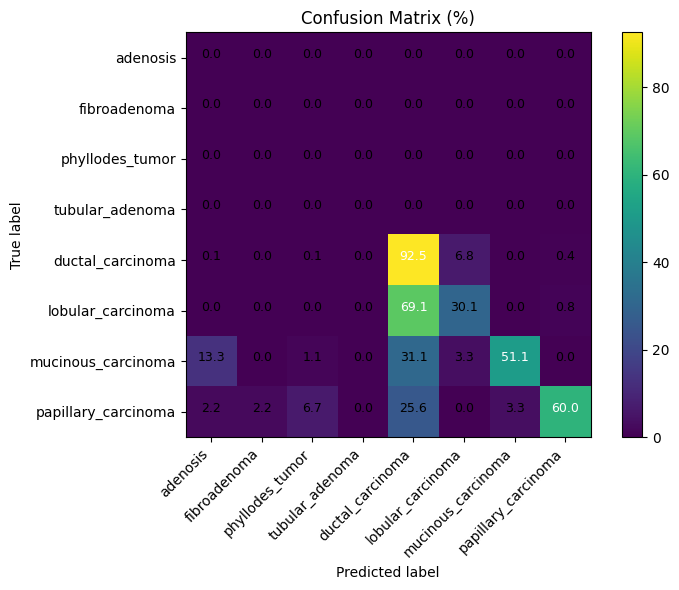

In [10]:
# Classification report & confusion matrix (test set)

y_true, y_pred = [], []

for batch_imgs, batch_labels in test_ds:
    logits = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(logits, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

labels = list(range(NUM_CLASSES))
target_names = [IDX2CLASS[i] for i in labels]

print("Test label counts:", np.bincount(y_true, minlength=NUM_CLASSES))  # sanity check

print("Classification Report (per class):")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=target_names,
    digits=4,
    zero_division=0    # avoid divide-by-zero warnings for missing classes
))

cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

def plot_conf_mat(matrix, class_names, normalize=True):
    import itertools
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    m = matrix if not normalize else (matrix * 100.0)
    plt.imshow(m, interpolation='nearest')
    plt.title("Confusion Matrix" + (" (%)" if normalize else ""))
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    thresh = (m.max() + m.min()) / 2.0
    for i, j in itertools.product(range(m.shape[0]), range(m.shape[1])):
        txt = f"{m[i, j]:.1f}" if normalize else str(int(m[i, j]))
        plt.text(j, i, txt, ha="center",
                 color="white" if m[i, j] > thresh else "black", fontsize=9)
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout(); plt.show()

plot_conf_mat(cm_norm, target_names, normalize=True)
